# 📈 Superstore Sales Prediction
This notebook explores whether various features (like order date, ship mode, customer segment, etc.) can predict sales using regression.

We will build a full machine learning pipeline using:
- Feature engineering
- Preprocessing with `ColumnTransformer`
- Modeling with `RandomForestRegressor`
- Hyperparameter tuning using `GridSearchCV`
- Cross-validation and feature importance


In [11]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

## 🔄 Load Data

In [12]:
# Load the Superstore dataset (update the path if needed)
df = pd.read_csv(r'C:\Users\Marsh\C6_ML5\Data\Raw\Sample - Superstore.csv', encoding='ISO-8859-1')

## 🛠 Feature Engineering

In [13]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month
df['Order_DayOfWeek'] = df['Order Date'].dt.dayofweek

## 🔍 Select Features & Target

In [14]:
# Drop unnecessary columns
df_model = df.drop(columns=['Order ID', 'Order Date', 'Ship Date', 'Customer ID', 
                            'Customer Name', 'Product Name', 'Product ID', 
                            'Country', 'City', 'State', 'Region', 'Row ID', 'Postal Code','Profit','Quantity'])

X = df_model.drop(columns=['Sales'])
y = df_model['Sales']

# Identify column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

## 🧱 Pipeline + GridSearchCV

In [15]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


## 📈 Evaluation

In [16]:
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
R² Score: 0.09726852932630237
RMSE: 730.2347047117767


## 📊 Cross-Validation Score

In [17]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE (per fold):", -cv_scores)
print("Average RMSE:", -np.mean(cv_scores))

Cross-validated RMSE (per fold): [479.47844302 677.82535959 532.27314034 629.34510283 603.05071699]
Average RMSE: 584.3945525566257


## 🔍 Feature Importance (Top 10)

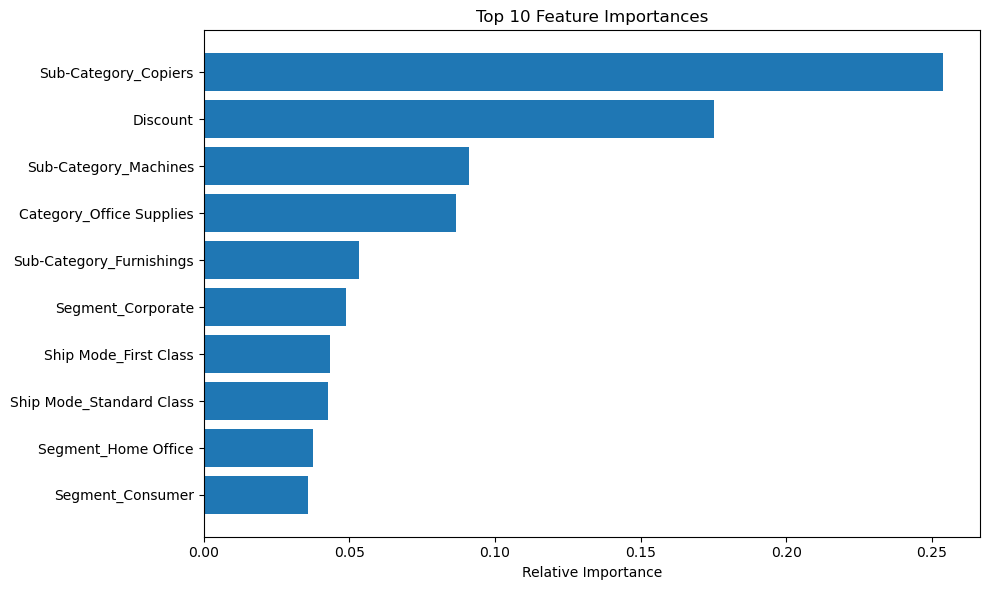

In [18]:
# Extract feature names after encoding
model = best_model.named_steps['regressor']
preprocessor = best_model.named_steps['preprocessor']

cat_ohe = preprocessor.named_transformers_['cat']
cat_feature_names = cat_ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Top 10 Feature Importances')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()